## Notes

In order to make the code work, this notebook should be inside the same folder as the images.
A sub-folder named "Foreground" should also exist in the same folder as the notebook and the images.

## Imports

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
from sklearn.cluster import KMeans

## Background substraction

My first idea was to extract the foreground, which is the moto. To do so, I designed the fg_extraction function, that uses the createBackgroundSubstractorMOG2 function of OpenCV. The results were noisy, so I created the post_processing function, subsequently applying a median filer, a threshold, and the erode and dilate function, to have the foreground mask with less noise.

In [23]:
def post_processing(img):
    median = cv2.medianBlur(img,5)
    thresh = cv2.threshold(median, 200, 255, cv2.THRESH_BINARY)[1]   
    thresh = cv2.erode(thresh, None, iterations=2)
    post = cv2.dilate(thresh, None, iterations=4)
    return post

In [22]:
def fg_extraction():
    """
    This function extracts the foreground from the background and delivers black and white images, the foreground being in white.
    """
    
    fgbg = cv2.createBackgroundSubtractorMOG2()
    for k in range(2):
        for i in range(30,192):
            if i<100:
                img_name="00"+str(i)
            else:
                img_name="0"+str(i)
            img = cv2.imread(img_name+'.jpg')
            fgmask = fgbg.apply(img)
            post=post_processing(fgmask)
            cv2.imwrite('Foreground\\fg_'+img_name+'.jpg',fgmask)
            cv2.imwrite('Foreground\\fg_post_'+img_name+'.jpg',post)

Once the foreground extracted, I need to count the big blobs inside the mask. To do so, we look for the connected components of the mask. If the size of the blob is big enough, we count the blob.

In [21]:
def blob_count(img,threshold=50,connectivity=4):
    img = cv2.imread(img,0) #0 is needed to open the image in grayscale.
    img[0:300,1400:]=0 #remove top_right corner
    output = cv2.connectedComponentsWithStats(img, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    count=0
    blobs=[]
    for label in range(1,num_labels):
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]
        x = stats[label, cv2.CC_STAT_LEFT]
        y = stats[label, cv2.CC_STAT_TOP]
        if width>=threshold and height>=threshold: #can instead use the number of white pixels.
            #roi = img[y:int(y+height), x:int(x+width)]
            #cv2.imwrite('blob_'+str(label)+'.jpg', roi)
            count+=1
            blobs.append([x, y, width, height])
    return count, blobs

The following function delivers the output where are printed how many motos are on each picture.

In [59]:
colors={0:'red',1:'green',2:'blue'} #dictionnary to store the corresponding colors

def is_there_motos():
    for i in range(30,192):
        if i<100:
            img_name="00"+str(i)
        else:
            img_name="0"+str(i)
        count, blobs = blob_count('Foreground\\fg_post_'+img_name+'.jpg')
        if count==0:
            print('There isn\'t any moto in the picture {}.'.format(img_name))
        elif count==1:
            print('There is one moto in the picture {}.'.format(img_name))
            
            img = cv2.imread(img_name+'.jpg')
            fg= cv2.imread('Foreground\\fg_post_'+img_name+'.jpg',0)
            fg_color=cv2.bitwise_and(img,img,mask = fg)
            
            for blob in blobs:
                x,y,width,height=blob
                img_blob=fg_color[y:int(y+height), x:int(x+width)]
                most_present_color=find_color(img_blob)
                most_present_color=most_present_color.index(max(most_present_color)) #index of the most dominant color
                
            print('The moto is {}.'.format(colors[most_present_color]))
            
        else:
            print('There are {} motos in the picture {}.'.format(count, img_name))
            
            img = cv2.imread(img_name+'.jpg')
            fg= cv2.imread('Foreground\\fg_post_'+img_name+'.jpg',0)
            fg_color=cv2.bitwise_and(img,img,mask = fg)
            
            colors_ranking=[]
            
            for blob in blobs:
                x,y,width,height=blob
                img_blob=fg_color[y:int(y+height), x:int(x+width)]
                most_present_color=find_color(img_blob)
                most_present_color=most_present_color.index(max(most_present_color)) #find the most dominant color for each blob
                colors_ranking.append([width*height,most_present_color]) #also store the area of the blob
            
            colors_ranking=sorted(colors_ranking, key=lambda x:x[0],reverse=True) #reverse it to start with largest blob
            for i in range(len(colors_ranking)):
                print('The moto in position {} is {}.'.format(i+1, colors[colors_ranking[i][1]])) 
            
            
            
    

## Color

In [53]:
def find_color(img):
    height, width = len(img), len(img[0])
    
    red = 0
    green = 0
    blue = 0
    count = 0
    
    for i in range(width):
        for j in range(height):
            colors=img[j][i]
            
            pix_red=colors[0]
            pix_green=colors[1]
            pix_blue=colors[2]
            
            if pix_red!=0 or pix_green!=0 or pix_blue !=0:
                red += pix_red
                green += pix_green
                blue += pix_blue
                count+=1
                
    return [red/count,green/count,blue/count]         

In [54]:
def find_color2(img_name):
    image = cv2.imread(img_name+'.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # cluster the pixel intensities
    clt = KMeans(n_clusters = 4)
    clt.fit(image)

    return clt.cluster_centers_
    

## Execution

In [7]:
fg_extraction()

In [60]:
is_there_motos()

There isn't any moto in the picture 0030.
There isn't any moto in the picture 0031.
There isn't any moto in the picture 0032.
There isn't any moto in the picture 0033.
There isn't any moto in the picture 0034.
There isn't any moto in the picture 0035.
There isn't any moto in the picture 0036.
There is one moto in the picture 0037.
The moto is red.
There is one moto in the picture 0038.
The moto is red.
There is one moto in the picture 0039.
The moto is red.
There is one moto in the picture 0040.
The moto is red.
There is one moto in the picture 0041.
The moto is red.
There is one moto in the picture 0042.
The moto is red.
There is one moto in the picture 0043.
The moto is red.
There is one moto in the picture 0044.
The moto is red.
There is one moto in the picture 0045.
The moto is red.
There is one moto in the picture 0046.
The moto is red.
There is one moto in the picture 0047.
The moto is red.
There is one moto in the picture 0048.
The moto is red.
There is one moto in the picture 0

The moto is green.
There is one moto in the picture 0174.
The moto is green.
There is one moto in the picture 0175.
The moto is green.
There is one moto in the picture 0176.
The moto is green.
There is one moto in the picture 0177.
The moto is green.
There is one moto in the picture 0178.
The moto is green.
There is one moto in the picture 0179.
The moto is green.
There is one moto in the picture 0180.
The moto is green.
There is one moto in the picture 0181.
The moto is green.
There is one moto in the picture 0182.
The moto is green.
There is one moto in the picture 0183.
The moto is green.
There is one moto in the picture 0184.
The moto is green.
There is one moto in the picture 0185.
The moto is green.
There is one moto in the picture 0186.
The moto is green.
There is one moto in the picture 0187.
The moto is green.
There is one moto in the picture 0188.
The moto is green.
There is one moto in the picture 0189.
The moto is green.
There is one moto in the picture 0190.
The moto is gr

## Test area

In [38]:
img_name='0114'
img = cv2.imread(img_name+'.jpg')
print(len(img))
print(len(img[0]))
tr_corner=img[0:300,1400:]
img[0:300,1400:]=0
cv2.imwrite('test.jpg',img)
    
    

1080
1920


True

In [42]:
img_name='0114'
img = cv2.imread(img_name+'.jpg')
fg= cv2.imread('Foreground\\fg_post_'+img_name+'.jpg',0)
print(find_color(cv2.bitwise_and(img,img,mask = fg)))
cv2.imwrite('test.jpg', cv2.bitwise_and(img,img,mask = fg))

[81.2862878695705, 80.78389098430466, 79.821073123251]


True

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

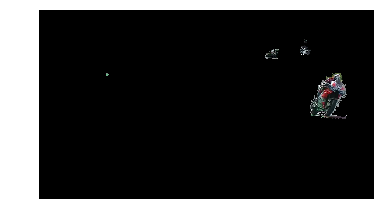

In [61]:


img_name='test'
image = cv2.imread(img_name+'.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure()
plt.axis("off")
plt.imshow(image)

image = image.reshape((image.shape[0] * image.shape[1], 3))

clt = KMeans(n_clusters = 4)
clt.fit(image)


In [62]:
print(clt.cluster_centers_)

[[6.27483238e-02 9.10392291e-02 8.97468432e-02]
 [1.20868755e+02 1.22656873e+02 1.22989749e+02]
 [1.93740874e+02 1.95246272e+02 1.97483805e+02]
 [5.69811590e+01 5.32693523e+01 5.45988844e+01]]
